In [1]:
# -*- coding: utf-8 -*-
#Robomaster Color Detection Code V0.1 By Weihang(Eric) Liang
#
#   Contributors:
#       V0.1: Weihang(Eric) Liang
#   Visualization:
#       Vivian Hu

import numpy as np  #numpy for doing calculations
import cv2  #Opencv 2
import matplotlib.pyplot as plt
from IPython.core.display import Image
import time

In [2]:
#Setting up boundaries for red, orange, blue and black
redH = [160,179]    #Red Hue Value Range
orangeH = [0,17]    #Orange Hue Value Range
blueH = [75,130]    #Blue Hue Value Range

S = [90,255]    #Saturation Factor (doesn't really matter)

V = [240,255]   #Value for light emitting devices

BlackV = [0,10] #Black value (darkness)

lowerredBound =  np.array([redH[0],S[0],V[0]])  #Setting up lower bounds for Red
upperredBound = np.array([redH[1],S[1],V[1]])   #Setting up higher bounds for Red

lowerorangeBound =  np.array([orangeH[0],S[0],V[0]])    #Setting up lower bounds for Orange (In effect Red)
upperorangeBound = np.array([orangeH[1],S[1],V[1]])     #Setting up higher bounds for Orange

lowerblueBound = np.array([blueH[0],S[0],V[0]])     #Setting up lower bounds for Blue
upperblueBound = np.array([blueH[1],S[1],V[1]])     #Setting up higher bounds for Blue

lowerblackBound = np.array([0,0,BlackV[0]])         #Setting up lower bounds for Black
upperblackBound = np.array([255,180,BlackV[1]])     #Setting up higher bounds for Black


In [3]:
##  Resize factor and Gaussian factor are the main two factors that affect the performance of this code
##  Range resizefactor 0.1 - 1.0 (0.5)
##  Range Gaussianfactor 3,5,7,9,11 (5)
##  Higher = Better quality in recognizing targets Lower = Faster

resizefactor = 0.5  #Resize the image to this factor

Gaussianfactor = 3  #Blur factor

def resize (frame, factor): #Resizes the frame by factor
    height, width = frame.shape[:2]
    #print("shape:")
    #print(frame.shape)
    if factor == 1:
        return frame
    elif factor < 1:
        size = (int(width * factor), int(height * factor))
        return cv2.resize(frame, size, interpolation=cv2.INTER_AREA)
    else:
        size = (int(width * factor), int(height * factor))
        return cv2.resize(frame, size, interpolation=cv2.INTER_CUBIC)

def maskHSV (hsvframe, lowerBound, upperBound, Gaussianfactor): #Masks the HSV frame using color bounds
    if lowerBound[0] > upperBound[0]:
        midBound1 = np.array([179,upperBound[1],upperBound[2]])
        midBound2 = np.array([0,lowerBound[1],lowerBound[2]])
        mask = cv2.inRange(hsvframe, lowerBound, midBound1)
        mask += cv2.inRange(hsvframe, midBound2, upperBound)
    else:
        mask = cv2.inRange(hsvframe, lowerBound, upperBound)
    mask = cv2.GaussianBlur(mask, (Gaussianfactor,Gaussianfactor), 0)
    return mask


def findRects (conts):  #Find the minAreaRects according to the contour
    rects = []
    for cont in conts:
        rect = cv2.minAreaRect(cont)
        rects.append(rect)
    return rects


def filterRects (rects):    #Filter the rects according to the characteristics of armor
    newrects = []
    for rect in rects:
        point, size, ang = rect
        h, w = size
        if (h / w > 1.5 and (abs(ang) > 60)) or ((w/h > 1.5) and (abs(ang)<30)):
            newrects.append(rect)
    return newrects

def resizeRects (rects, factor):    #Resize the rects back to normal size
    if factor == 1:
        return rects
    newrects = []
    for rect in rects:
        point, size, ang = rect
        h, w = size
        x, y = point
        h /= factor
        w /= factor
        x /= factor
        y /= factor
        rect = ((x, y), (h, w), ang)
        newrects.append(rect)
    return newrects

def drawRects (frame, rects, color):    #Draw the rects on the frame
    for rect in rects:
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(frame, [box], 0, color, 2)

def recttransform (size, ang):  #make all the rects in desired format
    newang = ang
    h,w = size
    if ang < -60:
        newang = -90 - ang
        return w,h,newang
    elif ang > 60:
        newang = 90 - ang
        return w,h,newang
    return h,w,ang

def findTargets (rects):    #Find the target armor using hard coded methods
    targets = []
    scores = []
    for a in range(len(rects)):
        for b in range(a+1, len(rects)):
            score = 0
            rect1 = rects[a]
            rect2 = rects[b]

            point1, size1, ang1 = rect1
            point2, size2, ang2 = rect2

            x1, y1 = point1
            x2, y2 = point2

            h1, w1, ang1 = recttransform(size1, ang1)
            h2, w2, ang2 = recttransform(size2, ang2)


            xmid = int((x1 + x2) / 2)
            ymid = int((y1 + y2) / 2)

            a1 = w1 * h1
            a2 = w2 * h2

            wavg = (w1 + w2) / 2
            aavg = (a1 + a2) / 2
            adiff = abs(a1 - a2)

            dist = np.sqrt((x2-x1)*(x2-x1)+(y2-y1)*(y2-y1))

            if (dist != 0):
                dwratio = dist / wavg
                score += 0.5 * abs(dwratio - 2) / 2
            else:
                score = 100

            if score < 5:
                targets.append((xmid, ymid))
                scores.append(score)

    sortedtargets = [target for _, target in sorted(zip(scores, targets))]
    return sortedtargets

In [4]:
start = time.time()
cap = cv2.VideoCapture('./test1.mp4')  #Open video file
print(cap.isOpened())
loop = 0
while (cap.isOpened()): #If there is video
    ret,frame = cap.read()  #Read the frame
    try:
        resizedframe = resize(frame, resizefactor)
        if(loop == 310):
            print("making image: " + str(loop))
            cv2.imwrite('testFrame.jpg', frame)
            break
    except:
        break
    loop += 1
print(time.time()-start)

True
making image: 310
26.037102222442627


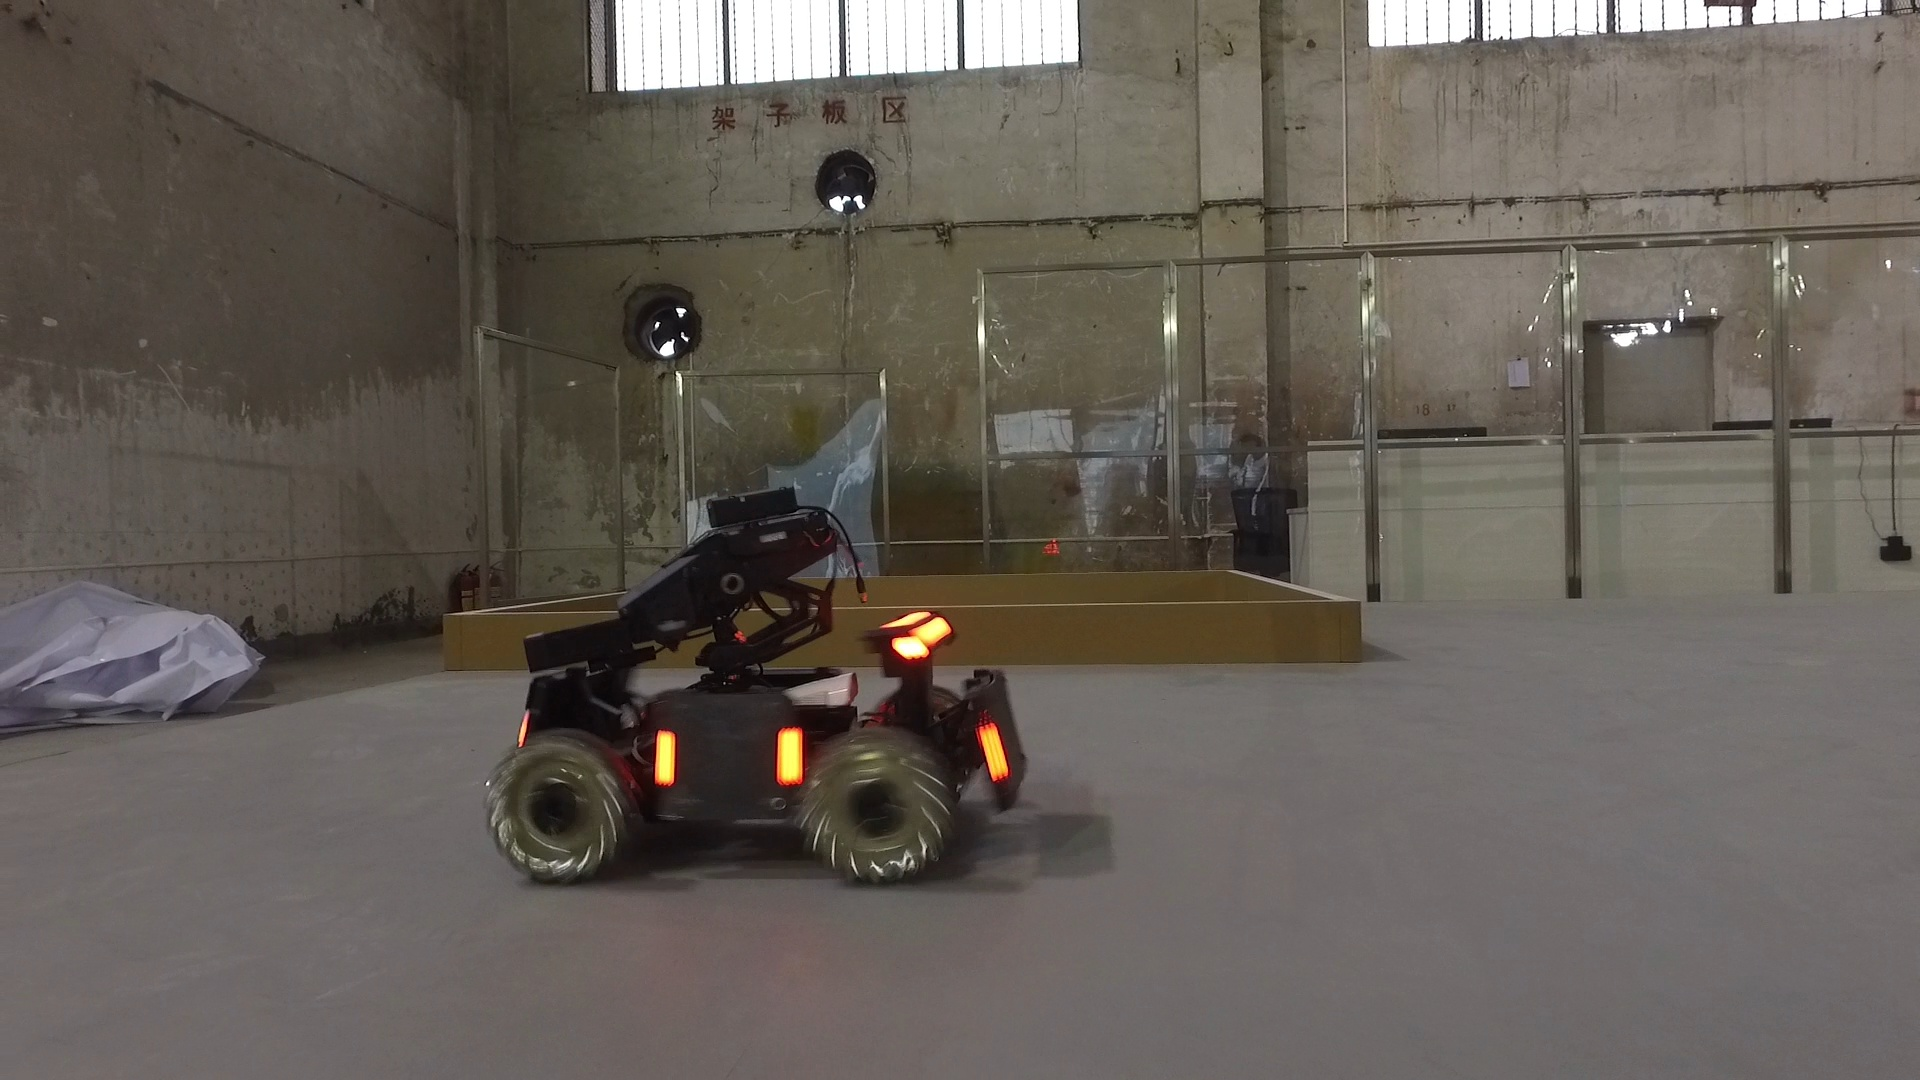

In [5]:
Image('./testFrame.jpg')
hsv = cv2.cvtColor(resizedframe, cv2.COLOR_BGR2HSV)    #Convert RGB to HSV for value check

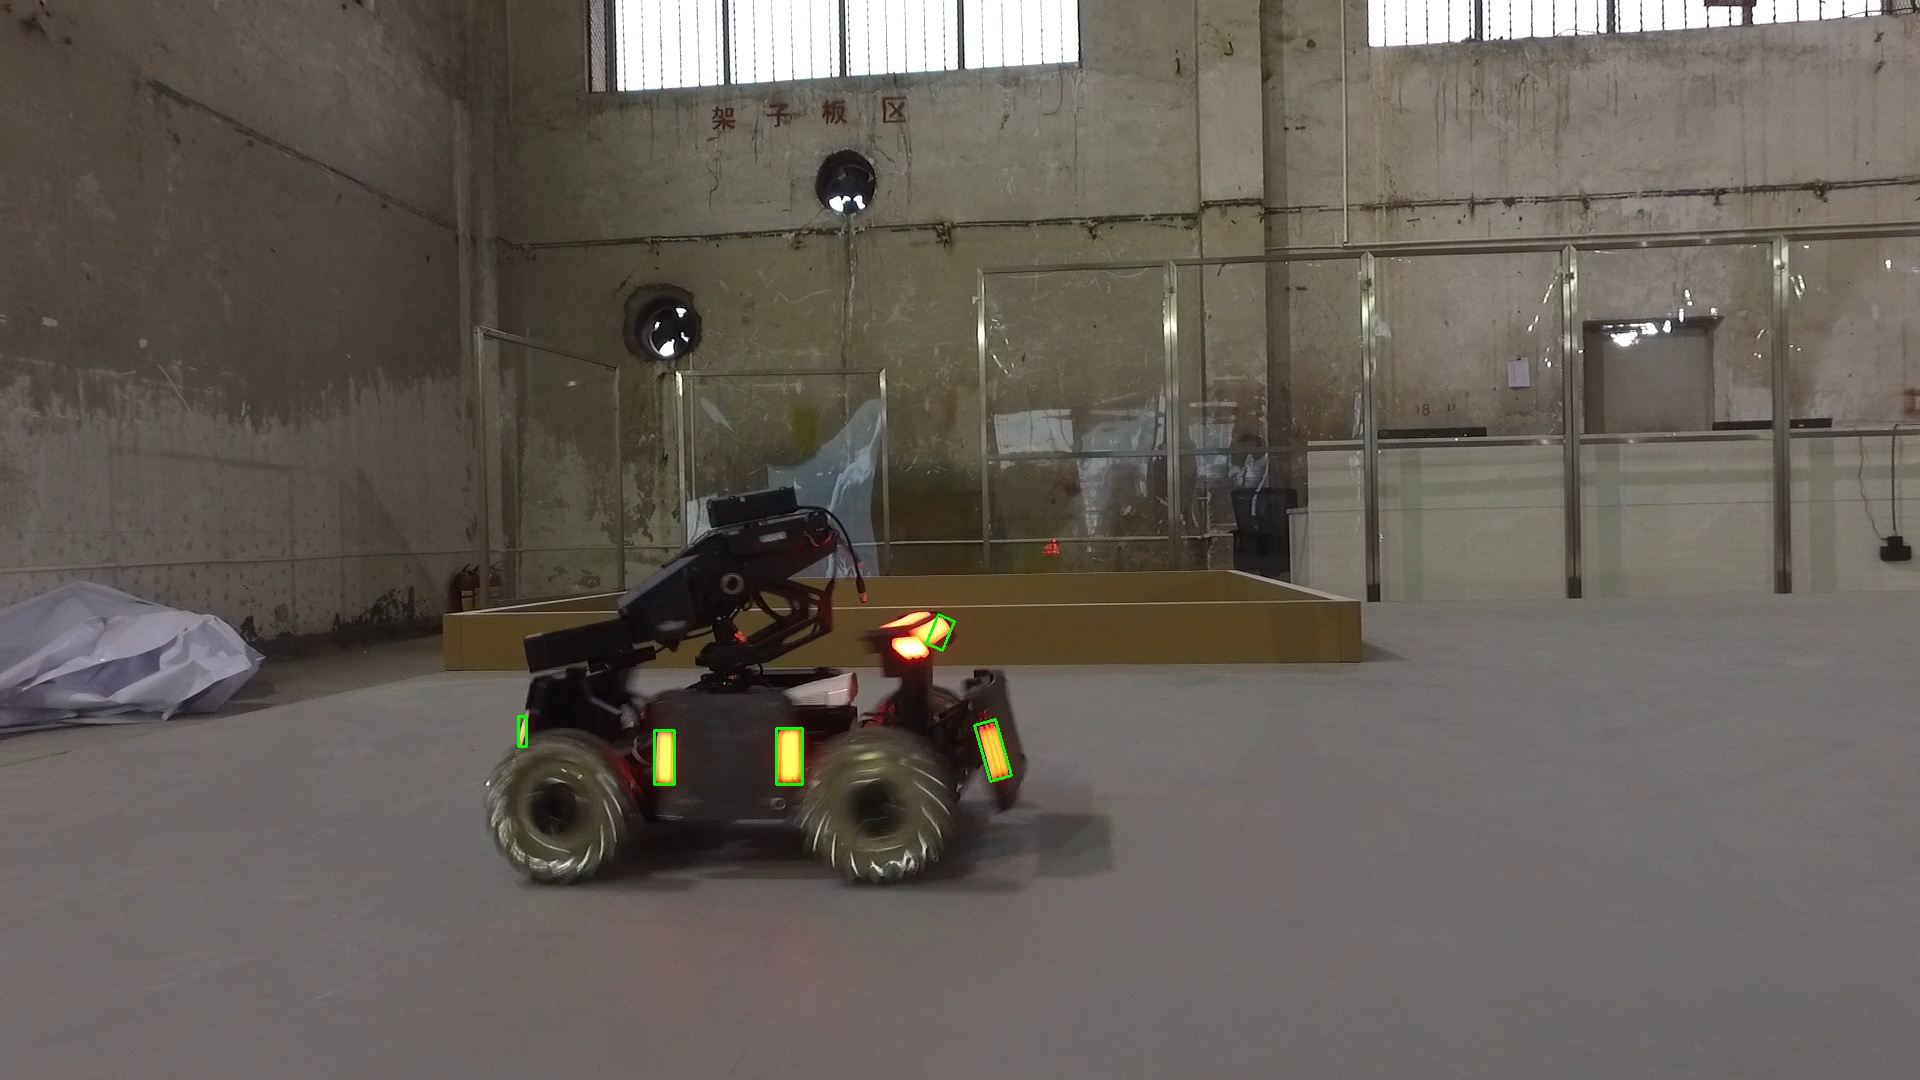

In [6]:


maskred = maskHSV(hsv, lowerredBound, upperorangeBound, Gaussianfactor)
maskblue = maskHSV(hsv, lowerblueBound, upperblueBound, Gaussianfactor)



# maskblack = maskHSV(hsv, lowerblackBound, upperblackBound)

im,redconts, hred = cv2.findContours(maskred.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)   #Finding contours of red points
im2,blueconts, hblue = cv2.findContours(maskblue.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)    #Finding contours of blue points

redrects = filterRects(findRects(redconts))

redrects = resizeRects(redrects,resizefactor)

drawRects(frame, redrects, (0, 255, 0))
cv2.imwrite('testFramewithContr.jpg', frame)
Image('testFramewithContr.jpg')

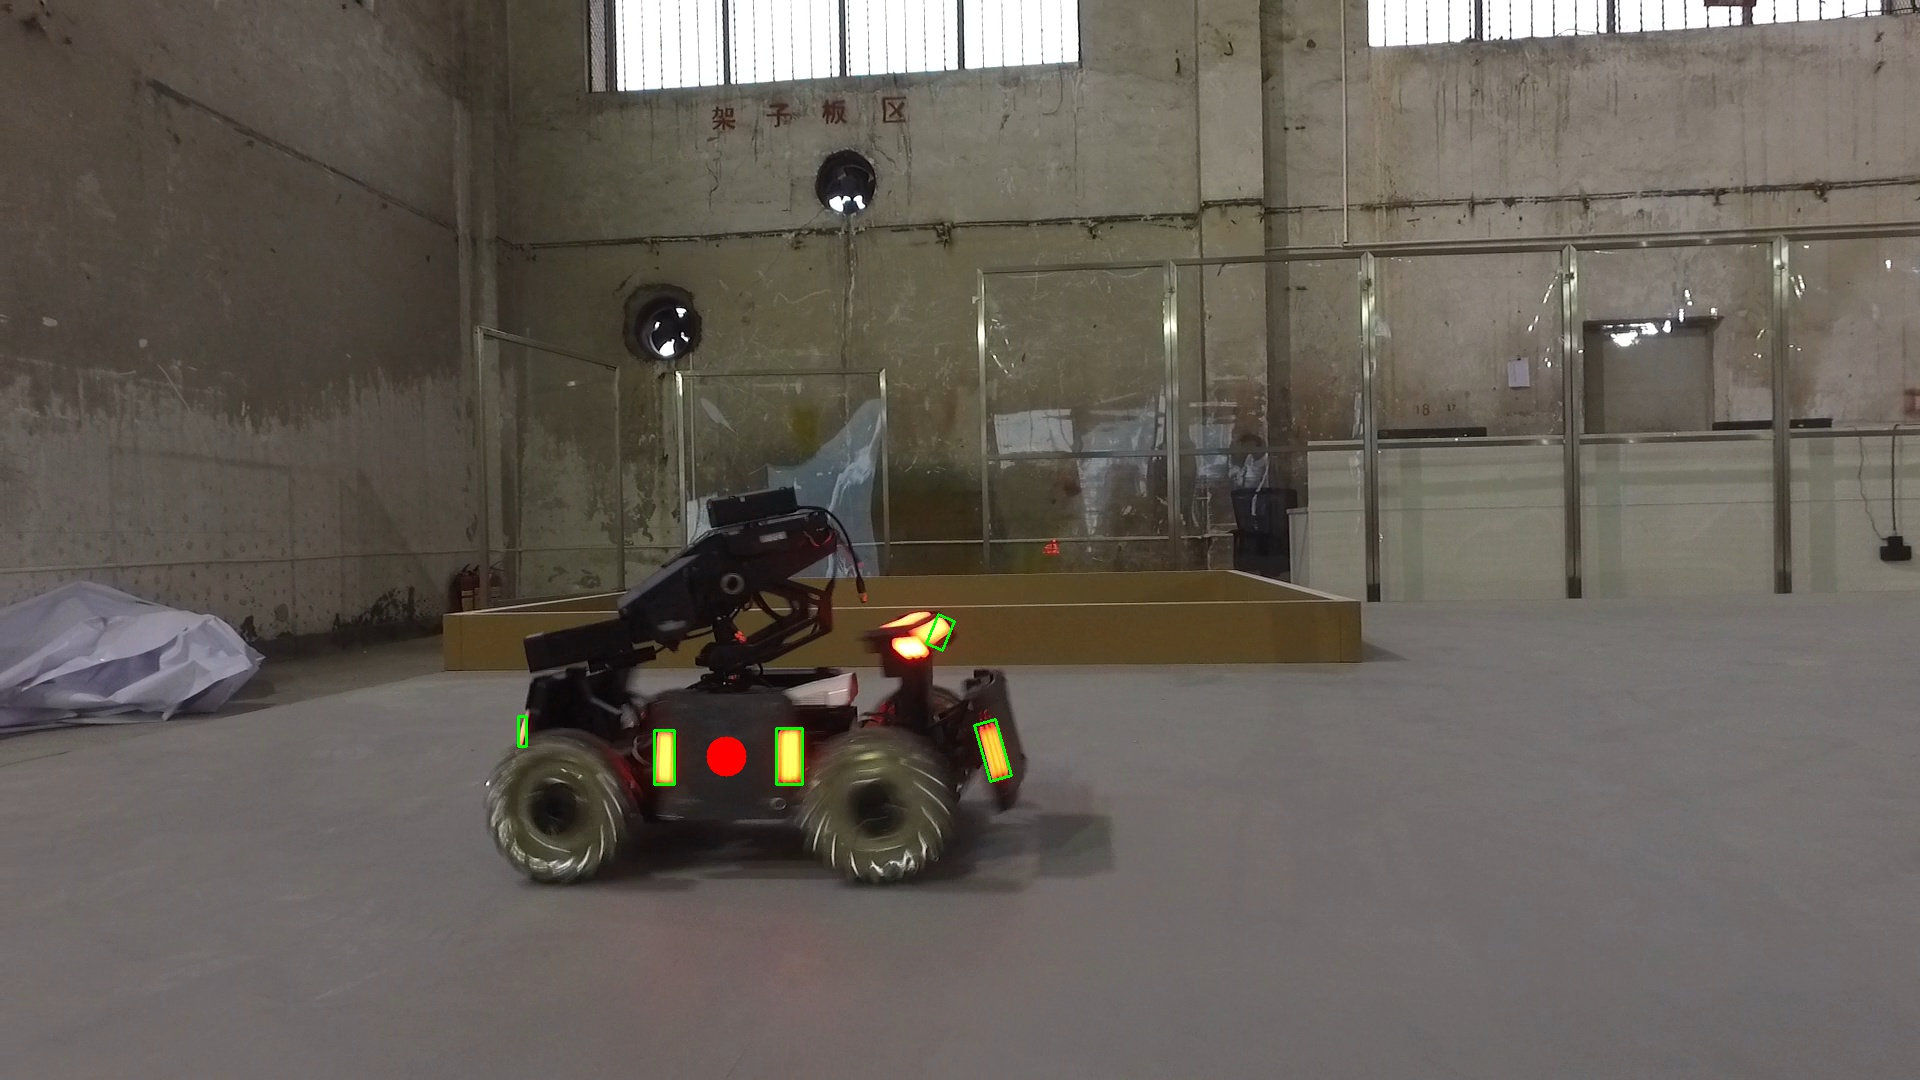

In [7]:
redtargets = findTargets(redrects)
for a in range(min(1, int(len(redtargets)))):
    cv2.circle(frame, redtargets[a], 20, (0, 0, 255), -1)

bluerects = filterRects(findRects(blueconts))

bluerects = resizeRects(bluerects, resizefactor)

drawRects(frame, bluerects, (0, 255, 255))
cv2.imwrite('testFramewithCircle.jpg', frame)
Image('testFramewithCircle.jpg')


In [8]:
bluetargets = findTargets(bluerects)
for a in range(min(1, int(len(bluetargets)))):
    cv2.circle(frame, bluetargets[a], 20, (230, 216, 173), -1)

In [ ]:
'''
cap = cv2.VideoCapture('./test1.mp4')  #Open video file
print(cap.isOpened())
loop = 0
while (cap.isOpened()): #If there is video
    ret,frame = cap.read()  #Read the frame
    try:
        resizedframe = resize(frame, resizefactor)
        if(loop >= 300 and loop <= 325):
            print("making image: " + str(loop))
            cv2.imwrite('frame_'+str(loop)+'.jpg', frame)
        elif loop >325:
            break
    except:
        break
    loop += 1
'''